## Exponentially Weighted Moving Average 

In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('Data/airline_passengers.csv', index_col=0, parse_dates=True)
# df['Month'] = df['Month'].shift(1)
print(df.isnull().sum())


Thousands of Passengers    0
dtype: int64


#### what is the frequency of the data? daily, monthly, ...
* by default it is none
* we can set a freq
* https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases

In [3]:
df.head()

,Thousands of Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [4]:
print(df.index.freq)
df.index.freq = 'MS'
print(df.index.freq)


None
<MonthBegin>


### Frist lets try SMA simple moving average
It is useful for identifying the overall direction of the data, detecting changes in trends, and reducing noise in the time series. SMA is straightforward to calculate and interpret, making it a popular tool for technical analysis, forecasting, and trend analysis.

<Axes: xlabel='Month'>

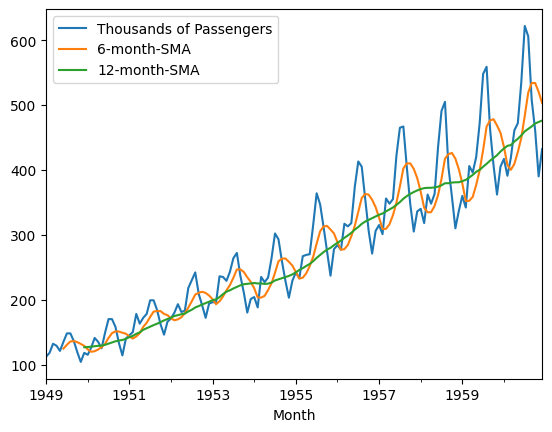

In [5]:
df['6-month-SMA'] = df['Thousands of Passengers'].rolling(window=6).mean()
df['12-month-SMA'] = df['Thousands of Passengers'].rolling(window=12).mean()
df.plot()

### EWMA has no lagging in the start

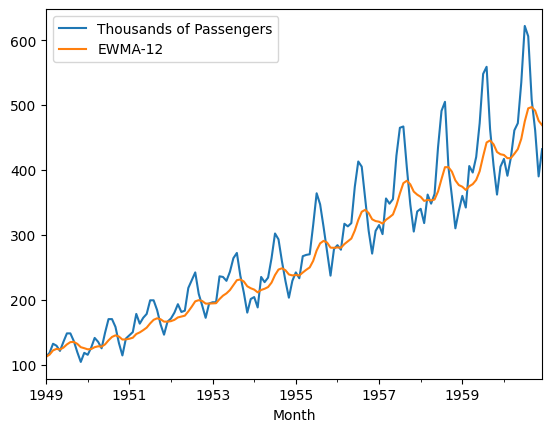

In [6]:
df['EWMA-12'] = df['Thousands of Passengers'].ewm(span=12).mean()
df[['Thousands of Passengers', 'EWMA-12']].plot();

### we can re-create the same as EWMA using simple smoothing exponential method

In [7]:
df = df[['Thousands of Passengers']]


In [8]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

#### How to set Alpha in EWMA

* 2/s+1 for span s >= 1
    * is the N-daily exponential Weighted moving average
* 1/1+c for center of mass c>=0
    * has more physical interpretation and can be thought of span: c=(s-1)/2
* 1-exp^log(0.5/h) for half-life h>0
    * Half-life is the period of time for the exponential weight to reduce to one half.
Span is the easiest to interpret



In [9]:
span = 12
alpha = 2/(span+1)

In [10]:
df['EWMA12'] = df['Thousands of Passengers'].ewm(alpha=alpha, adjust=False).mean()

/tmp/ipykernel_563772/2824926646.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['EWMA12'] = df['Thousands of Passengers'].ewm(alpha=alpha, adjust=False).mean()


In [11]:
fitted_model = SimpleExpSmoothing(df['Thousands of Passengers']).fit(smoothing_level=alpha, optimized=False)
df['SES12'] = fitted_model.fittedvalues.shift(-1) 
## values are exactly as EWMA12 but it is shifted down for some reason

/tmp/ipykernel_563772/2363001480.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SES12'] = fitted_model.fittedvalues.shift(-1)


<Axes: xlabel='Month'>

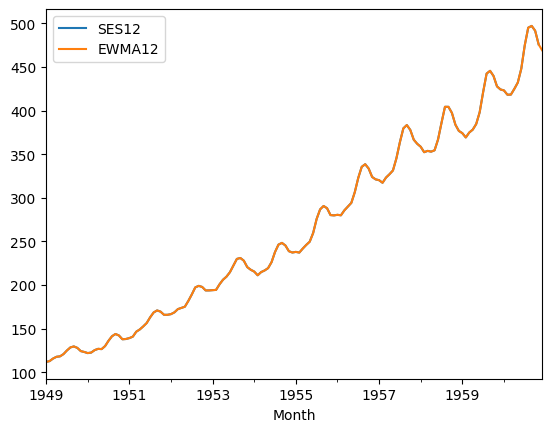

In [12]:
df[['SES12','EWMA12']].plot() ## full match

## Holt-Winters methods 
* allows to add on double and triple exponential smoothing.
* Equation of single exponential smoothing
    * y0 = x0
    * yt = (1-alpha)*yt-1 + alpha * xt
* Holts method (or double exponential smoothing) introduces a new smoothing factor Beta that addresses the trend.
* Holt-Winters method (triple exponential smoothing) can additionally account for seasonal fluctuation component by introducing another factor Gamma L


<Axes: xlabel='Month'>

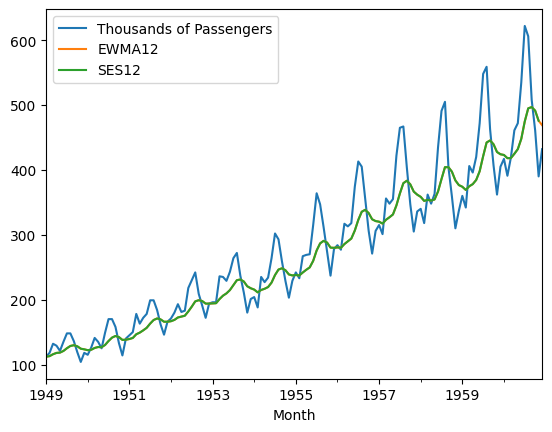

In [13]:
df.plot()

In [14]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
# trend, looking at hte graph above we can say that the trend is almost linear, so we set trend as additive than multiplicative
df['DES_add_12'] = ExponentialSmoothing(df['Thousands of Passengers'], trend='add').fit().fittedvalues.shift(-1)

In [15]:
df.head()

,Thousands of Passengers,EWMA12,SES12,DES_add_12
Month,,,,
1949-01-01,112,112.000000,112.000000,114.102394
1949-02-01,118,112.923077,112.923077,120.040657
1949-03-01,132,115.857988,115.857988,134.001539
1949-04-01,129,117.879836,117.879836,131.085845
1949-05-01,121,118.359861,118.359861,123.110263


In [16]:
df.columns.values

array(['Thousands of Passengers', 'EWMA12', 'SES12', 'DES_add_12'],
      dtype=object)

<Axes: xlabel='Month'>

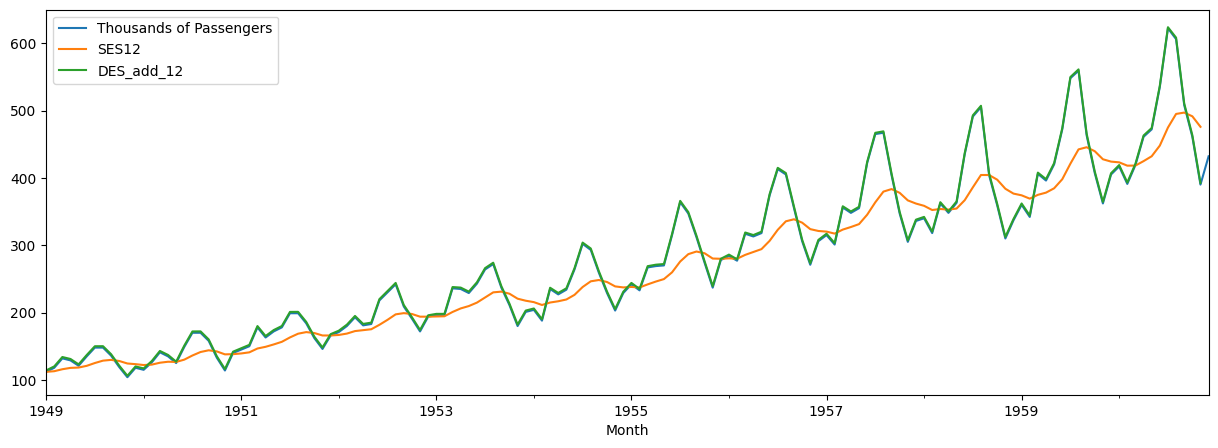

In [17]:
# we can see that DES falls very close to the actual value
df[['Thousands of Passengers', 'SES12', 'DES_add_12']].plot(figsize=(15,5))

<Axes: xlabel='Month'>

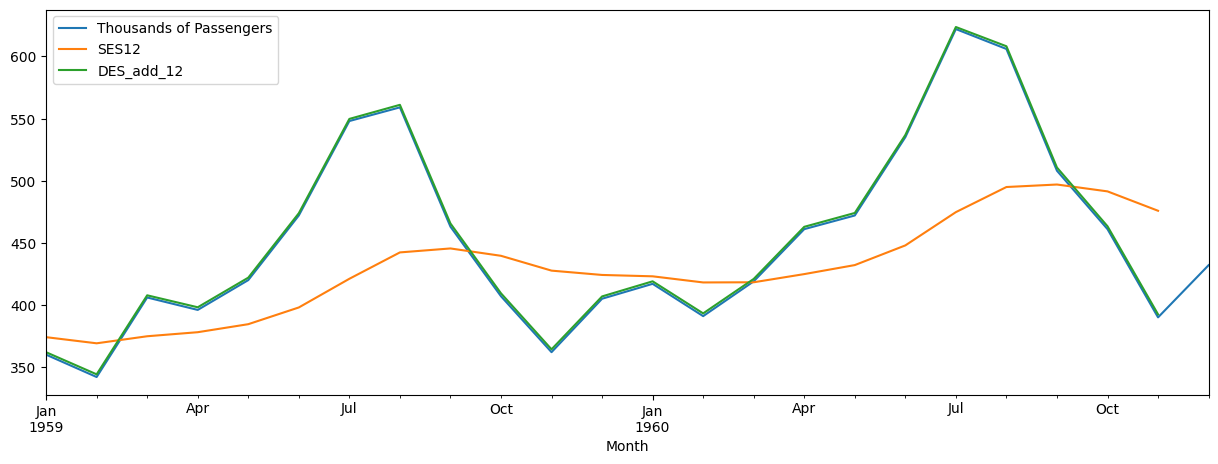

In [18]:
df[['Thousands of Passengers', 'SES12', 'DES_add_12']].iloc[-24:].plot(figsize=(15,5))

### Let us see the multiplicative trend

<Axes: xlabel='Month'>

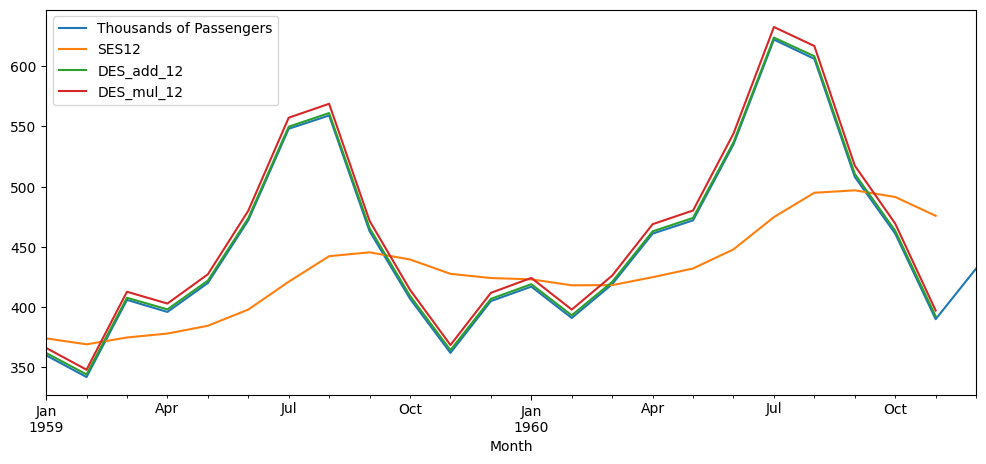

In [19]:
df['DES_mul_12'] = ExponentialSmoothing(df['Thousands of Passengers'], trend='mul').fit().fittedvalues.shift(-1)
df[['Thousands of Passengers', 'SES12', 'DES_add_12', 'DES_mul_12']].iloc[-24:].plot(figsize=(12,5))

### Tripple exponential smoothing

In [20]:
df['TES_mul_12'] = ExponentialSmoothing(df['Thousands of Passengers'], trend='mul', seasonal='mul', seasonal_periods=12).fit().fittedvalues


/jupyter/notebooks/.venvs/tensor_venv/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


<Axes: xlabel='Month'>

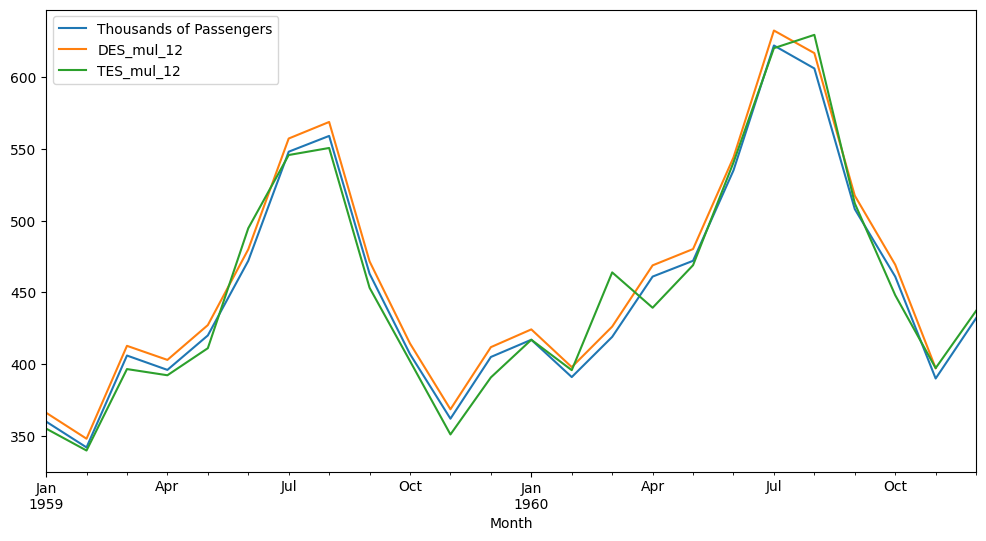

In [21]:
df[['Thousands of Passengers', 'DES_mul_12', 'TES_mul_12']].iloc[-24:].plot(figsize=(12,6))